In [1]:
include("load_data_dependencies.jl")

# Cut all neutrinos outside our energy smearing energy bounds

cut = energy_cut(rs0, ls0, bs0, rws0, us0, oneweights0, umin=log10(5e-1), umax=log10(4e3))
rs, ls, bs, rws, us, oneweights = cut[:,1], cut[:,2], cut[:,3], cut[:,4], cut[:,5], cut[:,6]

# Smear the log energy Monte Carlo
us_sm = smearuMC(us, esmearvec)

# Smear in angle
ls_sm, bs_sm = angsmearMC(ls, bs);

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    14-element Vector{Float64}:
│     0.0
│     0.022959230401096927
│     0.04405845113136857
│     0.07084030195235157
│     0.11232953691495227
│     ⋮
│     0.754237672954132
│     0.9555284363399403
│     0.9989955251533423
│     1.0000000000000002
│     1.0000000000000002
└ @ Interpolations ~/.julia/packages/Interpolations/y4lLj/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    15-element Vector{Float64}:
│     0.0
│     0.01947902682360647
│     0.0347242344133679
│     0.052785424819226066
│     0.09628136901295029
│     ⋮
│     0.7636614965974512
│     0.9723872952746974
│     0.999460162748707
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/y4lLj/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were 

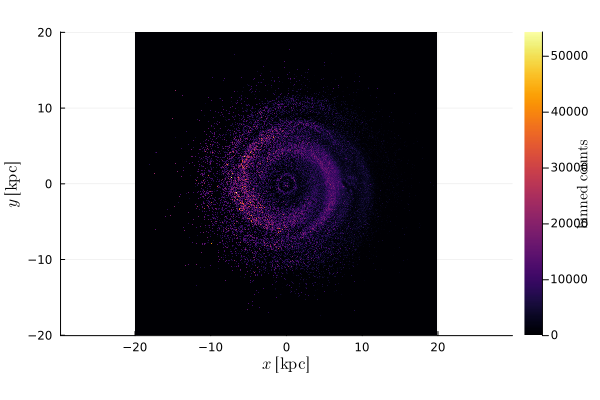

In [3]:
# Plotting the neutrino Galaxy:

xs, ys = cartx.(rs, ls, bs), carty.(rs, ls, bs)

xbins, ybins = -20:0.1:20, -20:0.1:20

galxy = StatsBase.fit(Histogram, (xs, ys), Weights(rws), (xbins, ybins), closed=:left).weights;

heatmap(
    xbins,
    ybins,
    transpose(galxy),
    aspect_ratio=1,
    xlabel=L"x~[\mathrm{kpc}]",
    ylabel=L"y~[\mathrm{kpc}]",
    colorbar_title=L"\mathrm{binned~counts}"
)

In [20]:
fitdist = Normal(0, 0.122)
fitdist_func(x) = pdf(fitdist, x)

fitdist_func (generic function with 1 method)

In [26]:
maximum(binnedψs.weights)/ fitdist_func(0)

43886.29348181047

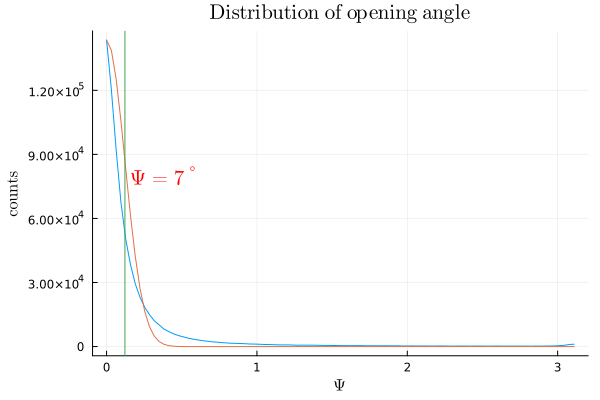

In [27]:
# Checking that this smearing does indeed smear as we would expect (i.e. Gaussian with width of 7 degrees)

ψs = zeros(length(ls))

for i in 1:length(ls)
    unsm = [ls[i], bs[i]]
    sm = [ls_sm[i], bs_sm[i]]
    dotprod = sum(sm .* unsm)
    ψ = acos(dotprod / (norm(sm) * norm(unsm)))
    ψs[i] = ψ
end

binnedψs = Distributions.fit(Histogram, ψs, range(0, π, 100))

plot(
    range(0, π, 100)[1:end-1],
    [binnedψs.weights 43886.29348181047*fitdist_func.(range(0, π, 100)[1:end-1])],
    xlabel=L"\Psi",
    ylabel=L"\mathrm{counts}",
    title=L"\mathrm{Distribution~of~opening~angle}",
    label=false
)
plot!(
    range(0, π, 100)[1:end-1],
    [0.122],
    seriestype=:vline,
    label=false
)
annotate!(
    0.4, 8e4, L"\Psi = 7^\circ", :red
)

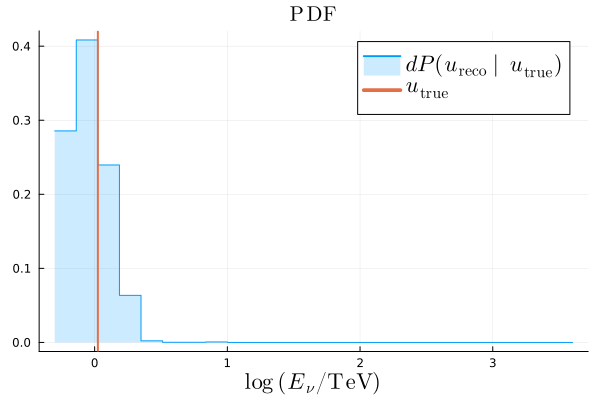

In [6]:
# Plotting a slice of the raw energy resolution matrix

plot(
    loges25, 
    eresbinned[:, 3], 
    seriestype=:step,
    title=L"\mathrm{PDF}",
    xlabel=L"\log~(E_{\nu}/\mathrm{TeV})",
    label=L"dP(u_\mathrm{reco}~|~u_\mathrm{true})",
    legendfontsize=15,
    xguidefontsize=15,
    yguidefontsize=15,
    fillrange=0,
    fillalpha=0.2
)
plot!(
    loges25,
    [loges25[3]],
    seriestype=:vline,
    label=L"u_\mathrm{true}",
    lw=2
)

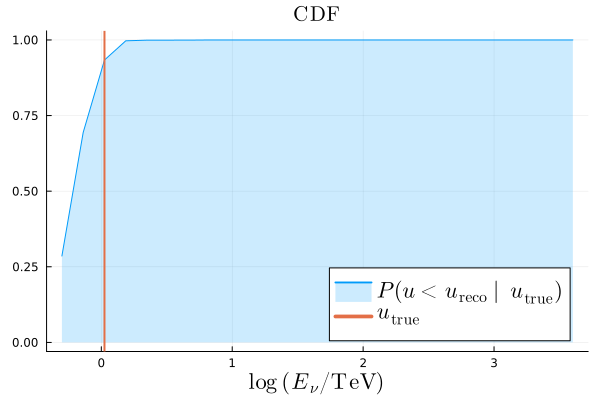

In [7]:
# Take the CDF of the matrix slice

loges25 = range(log10(5e-1), log10(4e3), 25)

countws = eresbinned[:, 3]

test_cdf = ecdf(loges25; weights=Weights(countws))

plot(
    loges25,
    test_cdf.(loges25),
    xlabel=L"\log~(E_\nu / \mathrm{TeV})",
    label=L"P(u < u_\mathrm{reco}~|~u_\mathrm{true})",
    title=L"\mathrm{CDF}",
    legendfontsize=15,
    xguidefontsize=15,
    yguidefontsize=15,
    fillrange=0,
    fillalpha=0.2
)
plot!(
    loges25,
    [loges25[3]],
    seriestype=:vline,
    label=L"u_\mathrm{true}",
    lw=2
)

In [9]:
# Take the inverse CDF to sample from (note that we force the function to be injective by forcing the first value of the
# CDF to be zero)

inv_cdf_non_extrap = Interpolations.interpolate((vcat([0], test_cdf.(loges25[2:12])),), loges25[1:12], Gridded(Linear())) # in m^2
inv_cdf = extrapolate(inv_cdf_non_extrap, Interpolations.Flat());

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    12-element Vector{Float64}:
│     0.0
│     0.6940782859895948
│     0.9336736213764039
│     0.9971537505975594
│     0.9992467120827437
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/y4lLj/src/gridded/gridded.jl:77


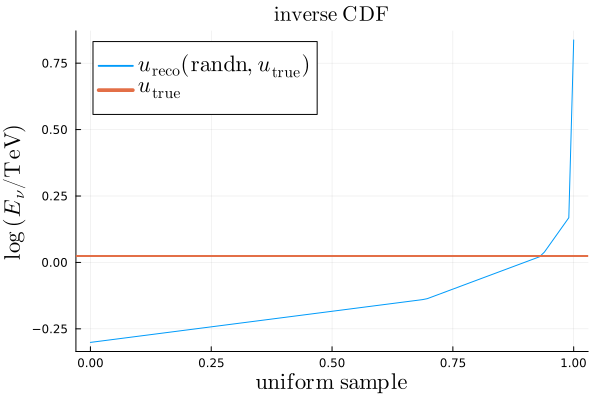

In [10]:
plot(
    range(0,1,100),
    inv_cdf.(range(0,1,100)),
    xlabel=L"\mathrm{uniform~sample}",
    ylabel=L"\log~(E_\nu / \mathrm{TeV})",
    label=L"u_\mathrm{reco}(\mathrm{randn}, u_\mathrm{true})",
    title=L"\mathrm{inverse~CDF}",
    legendfontsize=15,
    xguidefontsize=15,
    yguidefontsize=15,
)
plot!(
    loges25,
    [loges25[3]],
    seriestype=:hline,
    label=L"u_\mathrm{true}",
    lw=2
)

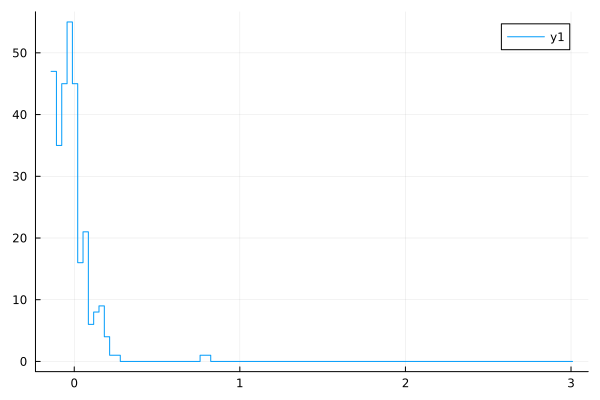

In [12]:
# Sampling from a uniform distribution and feeding through the CDF to reproduce the original slice

ubins = range(log10(emin), log10(emax), 100)

randnums = rand(1000)

esmeared = inv_cdf.(randnums)
esmeared_binned = Distributions.fit(Histogram, esmeared, ubins).weights

plot(
    ubins[1:end-1],
    esmeared_binned,
    seriestype=:step
)

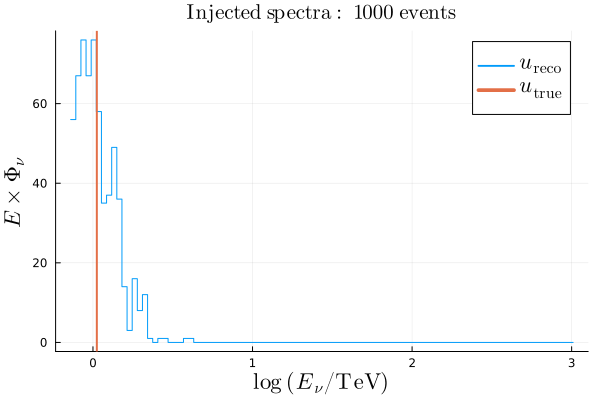

In [17]:
# Smearing some different distributions, including the neutrino model distributions

# Gives a delta function of energies to smear
us_t = zeros(1000) .+ loges25[3] .+ 0.001
us_sm_t = smearuMC(us_t, esmearvec)

us_b = Distributions.fit(Histogram, us_t, ubins).weights
us_sm_b = Distributions.fit(Histogram, us_sm_t, ubins).weights

plot(
    ubins[1:end-1],
    [us_sm_b],
    seriestype=:step,
    xlabel=L"\log~(E_\nu / \mathrm{TeV})",
    label= L"u_\mathrm{reco}",
    title=L"\mathrm{Injected~spectra:~1000~events}",
    ylabel=L"E \times \Phi_\nu",
    legendfontsize=15,
    xguidefontsize=15,
    yguidefontsize=15
)

plot!(
    loges25,
    [loges25[3]],
    seriestype=:vline,
    label=L"u_\mathrm{true}",
    lw=2
)

